In [998]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow_probability as tfp
import math

In [999]:
A = 100
B = 1
MOD = 157680
def stream_linear_time_series():
    for j in range(1, 100000000):
        yield A * j + B
        #yield (A * i + B) % MOD

In [1000]:
A = -0.01
B = -1
MOD = 157680
def stream_exp():
    for i in range(1, 100000000):
        x = A * i + B
        yield(tf.keras.activations.exponential(x))
    
A = -0.01
B = -1.
MOD = 157680
def stream_sin():
    for i in range(1, 100000000):
        x = A * i + B
        yield tf.math.sin(x)

In [1001]:
def generate_dataset(generator, dataset_len):
    y = np.array([next(generator) for i in range(dataset_len)], dtype=np.float32)
    X = np.array([[i] for i in range(1, 1 + y.shape[0])], dtype=np.float32)
    
    return X, y

##### График последовательности

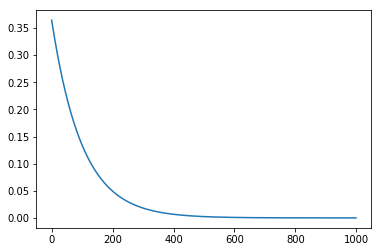

In [1008]:
generator = stream_exp()
sequance = []
for j in range(1000):
    sequance.append(next(generator))
plot.plot(sequance)
plot.show()

In [1009]:
X, y = generate_dataset(stream_exp(), 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, shuffle=True)

In [1010]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(500, 1)
(500,)
(500, 1)
(500,)


In [1011]:
# model = tf.keras.models.Sequential([
#     #tf.keras.layers.SimpleRNN(2, activation=tf.keras.activations.linear),
#     tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear)
# ])

In [1027]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense = tf.keras.layers.Dense(
            units=1, 
            activation=tf.keras.activations.exponential,
            kernel_initializer=tf.random_normal_initializer(mean=-1, stddev=1 / 3.),
            bias_initializer=tf.random_normal_initializer(),
            name='dense'
        )
        
    def __call__(self, x):
        return self.dense(x)[:, 0]

loss_object = tf.keras.losses.MeanSquaredError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.MeanSquaredError(name='test_accuracy')

In [1028]:
#@tf.function
def train_step(model, X, y, learning_rate):
 #   print(X, y)
#     print(X.shape, y.shape)
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = loss_object(y, predictions)
    
        
#     print(X.shape, y.shape, predictions.shape)
   # print("loss: ", loss)

#     print("y_true: ", y)
#     print("y_predict: ", predictions)
    
#     print("X: ", X)
#     print("kernel:", model.get_layer(name='dense').kernel.numpy())
#     print("bias:", model.get_layer(name='dense').bias.numpy())
    grad = tape.gradient(loss, model.trainable_variables)
    
    #print("grad: ", [i.numpy() for i in grad])
    #print("model.trainable_variables: ", model.trainable_variables)
    
   # print(grad, learning_rate)
    for (val, grad) in zip(model.trainable_variables, grad):
        val.assign(val - grad * learning_rate)
    #optimizer_instance.apply_gradients(zip(grad, model.trainable_variables))


    train_loss(loss)
    train_accuracy(y, predictions)

In [1029]:
@tf.function
def test_step(model, X, y):
    predictions = model(X)
    t_loss = loss_object(y, predictions)

    test_loss(t_loss)
    test_accuracy(y, predictions)

In [1030]:
def stream_batch(X, y, batch_size):
    assert(X.shape[0] == y.shape[0])
    X, y = shuffle(X, y)
    for i in range(0, X.shape[0] - batch_size + 1, batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

In [1031]:
EPOCHS = 10

In [1040]:
model = MyModel()
for epoch in range(EPOCHS):
  #  print("-" * 100)

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for x, y in stream_batch(X_train, y_train, batch_size=10):
        train_step(model, x, y, learning_rate=(0.1))

    test_step(model, X_test, y_test)
    
    template = 'Epoch {}, Loss: {}, MSE: {}, Test Loss: {}, Test MSE: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
    

#     print("-" * 100)
    print("kernel:", model.get_layer(name='dense').kernel.numpy())
    print("bias:", model.get_layer(name='dense').bias.numpy())

Epoch 1, Loss: 0.006026154849678278, MSE: 0.602615475654602, Test Loss: 0.006970304995775223, Test MSE: 0.6970304846763611
kernel: [[-1.2745914]]
bias: [0.03887003]
Epoch 2, Loss: 0.006026152987033129, MSE: 0.6026152968406677, Test Loss: 0.006970274727791548, Test MSE: 0.6970274448394775
kernel: [[-1.274522]]
bias: [0.03888344]
Epoch 3, Loss: 0.006026151590049267, MSE: 0.6026151776313782, Test Loss: 0.006970244459807873, Test MSE: 0.6970244646072388
kernel: [[-1.2744524]]
bias: [0.03889685]
Epoch 4, Loss: 0.0060261511243879795, MSE: 0.6026151180267334, Test Loss: 0.006970213260501623, Test MSE: 0.6970213055610657
kernel: [[-1.2743828]]
bias: [0.03891028]
Epoch 5, Loss: 0.0060261511243879795, MSE: 0.6026151180267334, Test Loss: 0.0069701834581792355, Test MSE: 0.6970183253288269
kernel: [[-1.2743132]]
bias: [0.0389237]
Epoch 6, Loss: 0.006026148796081543, MSE: 0.6026148796081543, Test Loss: 0.006970152258872986, Test MSE: 0.6970152258872986
kernel: [[-1.2742436]]
bias: [0.03893713]
Epoc

In [1018]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss='mean_squared_error',
#     metrics=['mean_absolute_error']
# )

In [979]:
model.fit(
    X_train, 
    y_train, 
    epochs=100,
    batch_size=2,
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
model.summary()

In [ ]:
pred = model.predict(np.array([100]))
print(pred)

In [ ]:
print(X_test[0:10])

In [ ]:
print(X_test[0:1].shape)

In [ ]:
plot.plot(pred)
plot.plot(y_test[0:100])

In [ ]:
model.summary()

In [ ]:
var1 = tf.Variable(initial_value=2023.)
var2 = tf.Variable(initial_value=-3456.)

loss = lambda: loss_object([var1, var2 * var2], [245., 47. ** 2]) #(var1 + 245) ** 2 + (var2 ** 2 - 47 * 47) ** 2

optimizer = tf.keras.optimizers.Adam
minimize(optimizer, loss, [var1, var2])
print(var1.numpy(), var2.numpy())

In [848]:
from scipy.optimize import minimize

In [902]:
def f(x):
    w = x[0]
    b = x[1]
    return loss_object(tf.math.exp(w * X_train + b)[:, 0], y_train)
    
res = minimize(f, [-4, 2], method='Nelder-Mead')
print(res)

 final_simplex: (array([[-0.01000362, -0.99997953],
       [-0.00999465, -1.00004649],
       [-0.01000603, -0.99992829]]), array([7.76838177e-11, 1.36568715e-10, 2.08367990e-10]))
           fun: 7.768381771189325e-11
       message: 'Optimization terminated successfully.'
          nfev: 117
           nit: 60
        status: 0
       success: True
             x: array([-0.01000362, -0.99997953])
